- 1차 모델 분류 결과 class 0, 5, 6에 해당하는 데이터 처리
- 2차 모델 : class 0 또는 class 5/6으로 분류
- RandomOverSampler로 소수 데이터 증강
- XGB 모델 구축

# Library

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Class Imbalance import
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [17]:
# Seed 고정
seed = 1
np.random.seed(seed)

# Load Data

In [18]:
# 원본 데이터 준비
df_org = pd.read_csv('data/multi_classification_data.csv')
df_org.shape

(1941, 34)

In [19]:
encoding_list = ['TypeOfSteel_A300', 'TypeOfSteel_A400']

# 오디날 인코딩 수행
df_org['Type_of_Steel'] = df_org[encoding_list].idxmax(axis=1).apply(lambda x: encoding_list.index(x))

# 오디날 인코딩된 컬럼 삭제
df_org = df_org.drop(encoding_list, axis=1)

# 결과 출력
print(df_org['Type_of_Steel'])

0       0
1       0
2       0
3       1
4       1
       ..
1936    1
1937    1
1938    1
1939    1
1940    0
Name: Type_of_Steel, Length: 1941, dtype: int64


In [20]:
target_list = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# 오디날 인코딩 수행
df_org['Target'] = df_org[target_list].idxmax(axis=1).apply(lambda x: target_list.index(x))

# 오디날 인코딩된 컬럼 삭제
df_org = df_org.drop(target_list, axis=1)

# 결과 출력
print(df_org['Target'])

0       0
1       0
2       0
3       0
4       0
       ..
1936    6
1937    6
1938    6
1939    6
1940    6
Name: Target, Length: 1941, dtype: int64


In [21]:
# Index / log 컬럼 삭제 데이터 준비
print(df_org.columns[12:25])

# Index, Log 컬럼 삭제 
# 1차 모델과 달리 'Empty_Index' 컬럼 추가 안함 (성능이 더 떨어지기 때문에)
columns_to_drop = [i for i in range(12, 25)]
df = df_org.drop(columns=df_org.columns[columns_to_drop])

# 'Target' 컬럼이 0 또는 5 또는 6인 행만 추출
df = df[(df['Target'] == 0) | (df['Target'] == 5) | (df['Target'] == 6)]

Index(['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object')


In [22]:
# 'Target' mapping
# class 0 --> 0 
# class 5 or 6 --> 1
df['Target'] = df['Target'].replace({5: 1, 6: 1})

# xgb로 학습시키려면 꼭 필요한 단계

In [23]:
# 행들을 뒤죽박죽으로 섞기
df = df.sample(frac=1, random_state=42)

### 데이터셋 분리 (train / val / test)

In [24]:
# target / feature 분리
target = 'Target'
x = df.drop(target, axis=1)
y = df[target]

In [25]:
## 데이터셋 분리 (train / val / test)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print(f'train data : x{x_train.shape}, y{y_train.shape}')
print(f'val data : x{x_val.shape}, y{y_val.shape}')
print(f'test data : x{x_test.shape}, y{y_test.shape}')


train data : x(998, 13), y(998,)
val data : x(111, 13), y(111,)
test data : x(124, 13), y(124,)


# Modeling

In [33]:
xgb = XGBClassifier(objective='binary:logistic')
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
# val set score
y_val_pred = xgb.predict(x_val)
val_report = classification_report(y_val, y_val_pred)
print(val_report)

              precision    recall  f1-score   support

           0       0.89      0.50      0.64        16
           1       0.92      0.99      0.95        95

    accuracy                           0.92       111
   macro avg       0.91      0.74      0.80       111
weighted avg       0.92      0.92      0.91       111



## Class Imbalance 해결

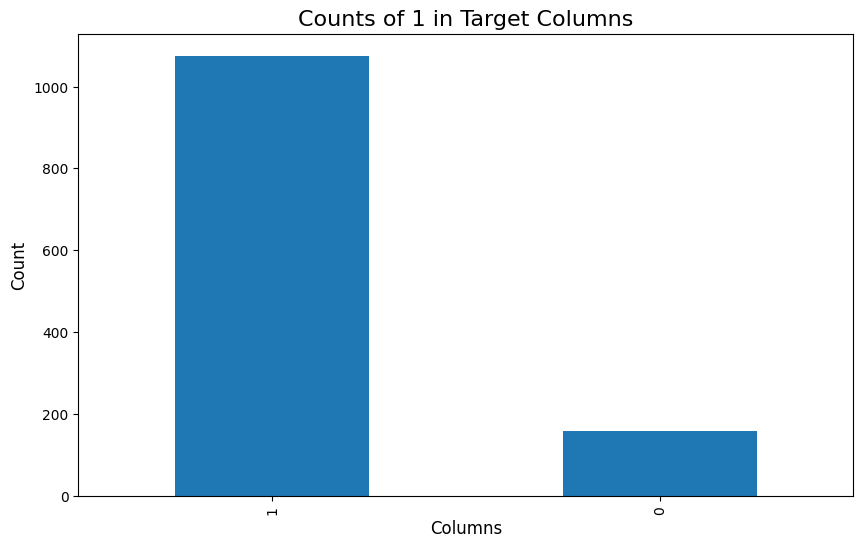

In [35]:
# target 분포 확인

# 컬럼별 1의 갯수 세기
counts = df['Target'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
counts.plot(kind='bar')  # 막대 그래프로 시각화
plt.title("Counts of 1 in Target Columns", fontsize=16)  # 그래프 제목 설정
plt.xlabel("Columns", fontsize=12)  # x축 레이블 설정
plt.ylabel("Count", fontsize=12)  # y축 레이블 설정
plt.show()  # 그래프 출력


In [36]:
o_sampler = RandomOverSampler(random_state=1)
x_train_o, y_train_o = o_sampler.fit_resample(x_train, y_train)
print(x_train_o.shape, y_train_o.shape)

(1740, 13) (1740,)


In [37]:
xgb.fit(x_train_o, y_train_o)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
# val set score after sampling
y_val_pred = xgb.predict(x_val)
val_report = classification_report(y_val, y_val_pred)
print(val_report)

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.94      1.00      0.97        95

    accuracy                           0.95       111
   macro avg       0.97      0.81      0.87       111
weighted avg       0.95      0.95      0.94       111



- tuning 후 accuracy 0.03 증가

# 하이퍼파라미터 튜닝

In [ ]:
# 튜닝할 하이퍼파라미터와 탐색 범위 설정
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [50, 100, 150, 200]
}

# GridSearchCV를 사용한 그리드 서치
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# tqdm을 사용하여 그리드 서치 실행
with tqdm(total=len(param_grid)) as pbar:
    grid_search.fit(x_train_o, y_train_o)
    pbar.update(1)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters found: ", grid_search.best_params_)

In [ ]:
# val set score after tuning
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(x_val)
val_report = classification_report(y_val, y_val_pred)
print(val_report)

# 최종 모델 평가

In [ ]:
# test set score after tuning
y_test_pred = best_model.predict(x_test)
test_report = classification_report(y_test, y_test_pred)
print(test_report)

# 모델 저장

In [42]:
import joblib
joblib.dump(best_model, 'steelplate_model2.pkl')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [44]:
import joblib
joblib.dump(xgb, 'binary1.pkl')

['binary1.pkl']